In [33]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os

## Build an unique dataset based on the PM25's median
1- Aggregate each data sensors hourly by applying a mean
2- Create an unique dataset by applying a median of each sensor in each hour

### Define constants

In [11]:
START_DATE_BOARD    = '2022-11-03'
END_DATE_BOARD      = '2023-06-15'
PM25_DIRECTORY      = '../resources/dataset/'
PM2_MAP = {
    "board20": ["s250.csv", "s252.csv", "s256.csv", "s258.csv"],
    "board21": ["s263.csv", "s265.csv", "s267.csv", "s269.csv"],
    "board22": ["s276.csv", "s278.csv", "s280.csv", "s282.csv"],
    "board25": ["s315.csv", "s317.csv", "s319.csv", "s321.csv"],
    "board29": ["s367.csv", "s369.csv", "s371.csv", "s373.csv"],
    "board31": ["s393.csv", "s395.csv", "s397.csv", "s399.csv"]
}

### Transform each CSV into Pandas dataframe

In [73]:
def change_hour_format(hour: str) -> str:
    return hour + ":00" if len(hour.split(':')) <= 2 else hour

def build_arpa_dataset(arpa_2022:str, arpa_2023:str) -> pd.DataFrame:
    df_arpa_2022 = pd.read_csv(arpa_2022, sep=';')
    df_arpa_2023 = pd.read_csv(arpa_2023, sep=';', index_col=False)
    df_arpa_2022.dropna(inplace=True)
    df_arpa_2023 = df_arpa_2023[df_arpa_2023.Stato == 'V']
    
    df_arpa = pd.DataFrame(columns=['timestamp', 'pm25'])
    data_series_2022 = df_arpa_2022['Data'] + " " + df_arpa_2022['Ora'].map(lambda x: change_hour_format(x))
    data_series_2023 = df_arpa_2023['Data rilevamento'] + ' ' + df_arpa_2023['Ora'].map(lambda x: change_hour_format(x))
    pm25_series = df_arpa_2022['PM2.5']
    
    data_series = pd.concat([data_series_2022, data_series_2023], ignore_index = True)
    pm25_series = pd.concat([pm25_series, df_arpa_2023['Valore']], ignore_index = True)
    
    df_arpa['timestamp']    = data_series
    df_arpa['pm25']         = pm25_series
    df_arpa.timestamp       = pd.to_datetime(df_arpa.timestamp, format="%d/%m/%Y %H:%M:%S")
    # Apply date range filter
    mask = (df_arpa['timestamp'] >= START_DATE_BOARD) & (df_arpa['timestamp'] <= END_DATE_BOARD)
    df_arpa = df_arpa.loc[mask]
    
    # Apply a special filter in which I remove all ARPA's values below 4
    df_arpa = df_arpa[df_arpa['pm25'] > 4]
    return df_arpa

df_arpa = build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv', '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv')

In [18]:
def prepare_pm25_dataframe(file_name: str) -> pd.DataFrame:
    df_pm25             = pd.read_csv(file_name) #mu_g/m^3
    df_pm25.timestamp   = pd.to_datetime(df_pm25.timestamp)
    df_pm25.drop_duplicates(inplace=True)
    df_pm25.sort_values(by='timestamp', inplace=True)
    df_pm25 = df_pm25.loc[(df_pm25['timestamp'] >= START_DATE_BOARD) & (df_pm25['timestamp'] <= END_DATE_BOARD)]
    df_pm25 = df_pm25.groupby(pd.Grouper(key='timestamp', freq='H')).mean().reset_index()
    df_pm25.dropna(inplace=True)
    return df_pm25

dataframes = []
for folder_name in tqdm(os.listdir(PM25_DIRECTORY), desc='Analyzing folders'):
    folder = os.path.join(PM25_DIRECTORY, folder_name)
    if os.path.isdir(folder) and len(folder.split('/')) > 3 and folder.split('/')[3] in PM2_MAP:
        files = PM2_MAP[folder.split('/')[3]]
        for file_name in files:
            file = os.path.join(folder, file_name)
            if os.path.isfile(file) and file.endswith(".csv"):
                df_pm25 = prepare_pm25_dataframe(file)
                dataframes.append(df_pm25)

Analyzing folders:   0%|          | 0/8 [00:00<?, ?it/s]

Start analyzing file ../resources/dataset/board22/s276.csv
Start analyzing file ../resources/dataset/board22/s278.csv
Start analyzing file ../resources/dataset/board22/s280.csv
Start analyzing file ../resources/dataset/board22/s282.csv


Analyzing folders:  12%|█▎        | 1/8 [00:24<02:52, 24.60s/it]

Start analyzing file ../resources/dataset/board25/s315.csv
Start analyzing file ../resources/dataset/board25/s317.csv
Start analyzing file ../resources/dataset/board25/s319.csv
Start analyzing file ../resources/dataset/board25/s321.csv


Analyzing folders:  25%|██▌       | 2/8 [03:00<10:10, 101.80s/it]

Start analyzing file ../resources/dataset/board31/s393.csv
Start analyzing file ../resources/dataset/board31/s395.csv
Start analyzing file ../resources/dataset/board31/s397.csv
Start analyzing file ../resources/dataset/board31/s399.csv


Analyzing folders:  62%|██████▎   | 5/8 [04:23<02:26, 48.82s/it] 

Start analyzing file ../resources/dataset/board20/s250.csv
Start analyzing file ../resources/dataset/board20/s252.csv
Start analyzing file ../resources/dataset/board20/s256.csv
Start analyzing file ../resources/dataset/board20/s258.csv


Analyzing folders:  75%|███████▌  | 6/8 [05:15<01:39, 49.66s/it]

Start analyzing file ../resources/dataset/board29/s367.csv
Start analyzing file ../resources/dataset/board29/s369.csv
Start analyzing file ../resources/dataset/board29/s371.csv
Start analyzing file ../resources/dataset/board29/s373.csv


Analyzing folders:  88%|████████▊ | 7/8 [07:18<01:08, 68.99s/it]

Start analyzing file ../resources/dataset/board21/s263.csv
Start analyzing file ../resources/dataset/board21/s265.csv
Start analyzing file ../resources/dataset/board21/s267.csv
Start analyzing file ../resources/dataset/board21/s269.csv


Analyzing folders: 100%|██████████| 8/8 [08:50<00:00, 66.34s/it]


### Get an unique dataframe by applying the median in each point

In [62]:
df_pm25                 = pd.DataFrame(columns=['timestamp', 'data'])
df_pm25['timestamp']    = pd.date_range(start=START_DATE_BOARD, end=END_DATE_BOARD, freq='H')
pm25_series             = []

for pit in tqdm(df_pm25['timestamp'], desc='Building unique dataset'):
    pm25_values = []
    for df in dataframes:
        value = df[df.timestamp == pit]['data'].values
        if len(value) > 0:
            pm25_values.append(value[0])
        #else:
        #    pm25_values.append(0)
    pm25_series.append(np.median(pm25_values) if len(pm25_values) > 0 else None)

df_pm25['data']    = pd.Series(pm25_series)
df_pm25.dropna(inplace=True)
df_pm25.to_csv('../resources/dataset/unique_timeserie_by_median.csv', index=False)

Building unique dataset: 100%|██████████| 5377/5377 [01:15<00:00, 70.76it/s]


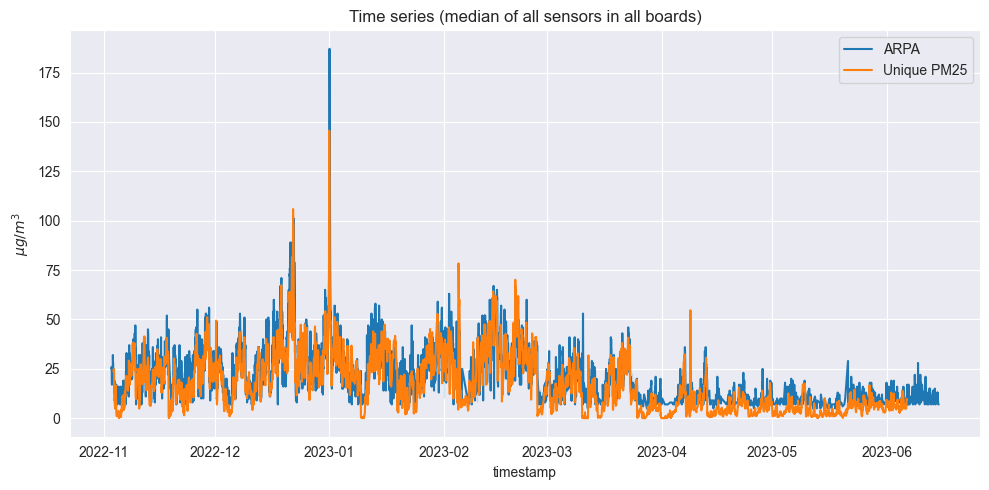

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(x = "timestamp", y = "pm25", data = df_arpa, ax=ax, label='ARPA')
sns.lineplot(x = "timestamp", y = "data", data = df_pm25, ax=ax, label='Unique PM25')
ax.set_ylabel(r'$\mu g/m^3$')
ax.set_title('Time series (median of all sensors in all boards)')
ax.grid()
plt.grid()
fig.tight_layout()
plt.show()

## Start with LSTM model

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Prepare dataset

In [84]:
df_sensors              = pd.read_csv('../resources/dataset/unique_timeserie_by_median.csv')
df_sensors.timestamp    = pd.to_datetime(df_sensors.timestamp)
df_arpa                 = build_arpa_dataset('../resources/dataset/arpa/Dati PM10_PM2.5_2020-2022.csv'
                                     , '../resources/dataset/arpa/Torino-Rubino_Polveri-sottili_2023-01-01_2023-06-30.csv')

df          = df_sensors.merge(df_arpa, left_on=['timestamp'], right_on=['timestamp'])
df.rename(columns={"data": "x", "pm25": "y"}, inplace=True)

TRAIN_TEST_SIZE = 0.8
train_data  = df.x.values[: int(len(df.x.values)  * TRAIN_TEST_SIZE)]
test_data   = df.x.values[int(len(df.x.values) * TRAIN_TEST_SIZE) :]
# Convert the time series data to PyTorch tensors
train_data  = torch.FloatTensor(train_data).unsqueeze(1)
test_data   = torch.FloatTensor(test_data).unsqueeze(1)

### Create the model structure

In [86]:
class MyLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size    = hidden_size
        self.lstm           = nn.LSTM(input_size, hidden_size)
        self.fc             = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        batch_size          = input.size(0)
        hidden              = self.init_hidden(batch_size)
        lstm_out, hidden    = self.lstm(input.view(len(input), batch_size, -1), hidden)
        output              = self.fc(lstm_out[-1])
        return output

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))